In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

In [ ]:
!unzip -q face-mask-detection.zip

In [1]:
from glob import glob
import os
import xml.etree.ElementTree as ET
from PIL import Image
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import albumentations as A
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

print('tensorflow version: ', tf.version.VERSION)

tensorflow version:  2.4.1


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
annotations = glob('annotations/*.xml')
print('#annotations: ', len(annotations))

#annotations:  857


In [4]:
def read_xml(filepath):
    """
    output:
        img: PIL.Image
        label: array of
            'name': name of class
            'bounding_box': [y1, x1, y2, x2]
    """
    tree = ET.parse(filepath)
    root = tree.getroot()
    
    folder = None
    filename = None
    label = []
    for child in root:
        if child.tag == 'folder':
            folder = child.text
        elif child.tag == 'filename':
            filename = child.text
        elif child.tag == 'object':
            name = None
            bounding_box = [0, 0, 0, 0]
            for b in child:
                if b.tag == 'name':
                    name = b.text
                elif b.tag == 'bndbox':
                    for c in b:
                        if c.tag == 'xmin':
                            bounding_box[0] = int(c.text)
                        elif c.tag == 'ymin':
                            bounding_box[1] = int(c.text)
                        elif c.tag == 'xmax':
                            bounding_box[2] = int(c.text)
                        elif c.tag == 'ymax':
                            bounding_box[3] = int(c.text)
            label.append({
                'name': name,
                'bounding_box': bounding_box
            })
    img = Image.open(os.path.join(folder, filename)).convert('RGB')
    
    return img, label
        

print(annotations[0])
read_xml(annotations[0])

annotations/maksssksksss8.xml


(<PIL.Image.Image image mode=RGB size=301x400 at 0x7F92EC565550>,
 [{'name': 'with_mask', 'bounding_box': [75, 271, 152, 385]}])

In [5]:
def load_data():
    data = []
    class_count = {}
    for xml_path in annotations:
        img, label = read_xml(xml_path)
        size = img.size
        for l in label:
            box = l['bounding_box']
            name = l['name']
            if name not in class_count:
                class_count[name] = 1
            else:
                class_count[name] += 1
        data.append({
            'img': img,
            'label': label
        })
    print(class_count)
    return data


data = load_data()
print('data size: ', len(data))

{'with_mask': 3234, 'mask_weared_incorrect': 123, 'without_mask': 719}
data size:  857


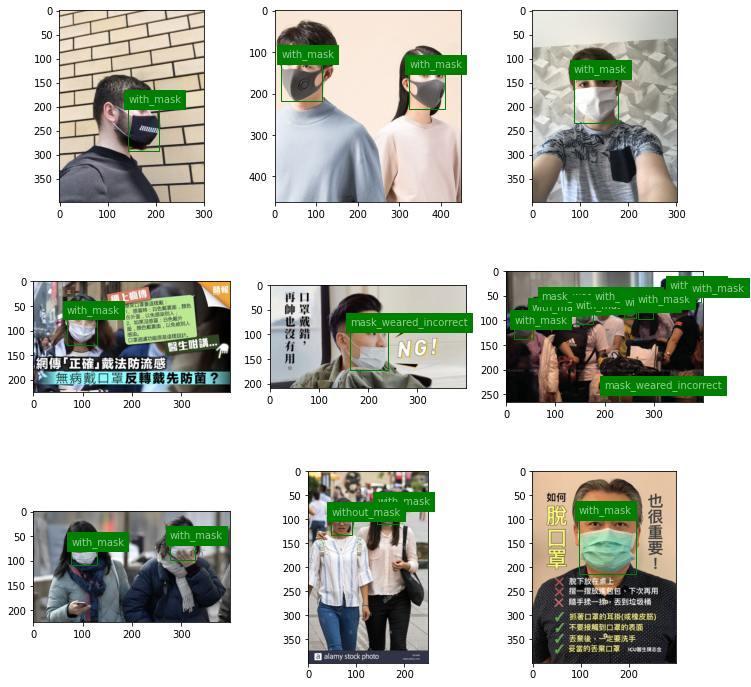

In [6]:
plt.figure(figsize=(12, 12))
for i in range(9):
    index = np.random.randint(0, len(data))
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(data[index]['img'])
    for l in data[index]['label']:
        name = l['name']
        box = l['bounding_box']
        x1 = box[0]
        y1 = box[1]
        x2 = box[2]
        y2 = box[3]
        w = x2-x1
        h = y2-y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, name, backgroundcolor='g', color='w', alpha=0.6)

plt.show()

In [7]:
IMAGE_SIZE = 300
LABEL_MAPPING = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2
}

def image_resize(entry):
    img = entry['img']
    size = img.size
    label = entry['label']
    new_label = []
    for l in label:
        new_bounding_box = [b for b in l['bounding_box']]
        for i in range(4):
            new_bounding_box[i] = np.clip(new_bounding_box[i], 0, size[i%2])
        
        if new_bounding_box[0] >= new_bounding_box[2] or new_bounding_box[1] >= new_bounding_box[3]:
            continue
        for i in range(4):
            new_bounding_box[i] = new_bounding_box[i] / size[i%2] * IMAGE_SIZE
        new_label.append({
            'class_label': LABEL_MAPPING[l['name']],
            'bounding_box': new_bounding_box,
        })
    return {
        'img': img.resize((IMAGE_SIZE, IMAGE_SIZE)),
        'label': new_label,
    }


def rotate_bounding_box(box, degree, img_center):
    x = np.array([[box[0], box[2], box[0], box[2]], [box[1], box[1], box[3], box[3]], [1., 1., 1., 1.]])
    t1 = np.array([[1., 0., -img_center[0]], [0., 1., -img_center[1]], [0., 0., 1.]])
    r = -degree / 180.0 * np.pi
    r1 = np.array([[np.cos(r), -np.sin(r), 0.], [np.sin(r), np.cos(r), 0.], [0., 0., 1]])
    t2 = np.array([[1., 0., img_center[0]], [0., 1., img_center[1]], [0., 0., 1.]])
    y = t2 @ r1 @ t1 @ x
    xmin = np.min(y[0, :])
    xmax = np.max(y[0, :])
    ymin = np.min(y[1, :])
    ymax = np.max(y[1, :])
    return [xmin, ymin, xmax, ymax]


def random_rotate(entry, rotate_prob=0.5, max_degree=20.0):
    if np.random.uniform() < rotate_prob:
        img = entry['img']
        label = entry['label']
        degree = np.random.uniform(-max_degree, max_degree)
        img_center = [s/2 for s in img.size]
        new_label = []
        for l in label:
            new_bounding_box = [b for b in l['bounding_box']]
            rotated = rotate_bounding_box(new_bounding_box, degree, img_center)
            new_label.append({
                'name': l['name'],
                'bounding_box': rotated,
            })
        return {
            'img': img.rotate(degree, fillcolor='black'),
            'label': new_label,
        }
    return entry


def random_crop(entry, crop_prob=0.5, crop_percent=0.6):
    img = entry['img']
    w, h = img.size
    label = entry['label']
    if np.random.uniform() < crop_prob:
        w_percent = np.random.uniform(crop_percent, 1.0)
        h_percent = np.random.uniform(crop_percent, 1.0)
        new_w = int(w * w_percent)
        new_h = int(h * h_percent)
        
        new_x = np.random.randint(0, w-new_w)
        new_y = np.random.randint(0, h-new_h)
        new_label = []
        for l in label:
            new_bounding_box = [b for b in l['bounding_box']]
            new_bounding_box[0] = new_bounding_box[0] - new_x
            new_bounding_box[1] = new_bounding_box[1] - new_y
            new_bounding_box[2] = new_bounding_box[2] - new_x
            new_bounding_box[3] = new_bounding_box[3] - new_y
            new_label.append({
                'name': l['name'],
                'bounding_box': new_bounding_box,
            })
        return {
            'img': img.crop((new_x, new_y, new_x+new_w, new_y+new_h)),
            'label': new_label,
        }
    return entry


def random_flip(entry, flip_prob=0.5):
    img = entry['img']
    size = img.size
    label = entry['label']
    new_label = []
    if np.random.uniform() < flip_prob:
        for l in label:
            new_bounding_box = [b for b in l['bounding_box']]
            for i in range(0, 4, 2):
                new_bounding_box[i] = size[i%2] - new_bounding_box[i]
            new_bounding_box[0], new_bounding_box[2] = new_bounding_box[2], new_bounding_box[0]
            new_label.append({
                'name': l['name'],
                'bounding_box': new_bounding_box
            })
        return {
            'img': img.transpose(method=Image.FLIP_LEFT_RIGHT),
            'label': new_label,
        }
    return entry


random_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.5),
    A.HueSaturationValue(),
    A.CoarseDropout(max_holes=10, max_height=16, max_width=16),
])


def augmentation(entry,
                 rotate_prob=0.5,
                 max_degree=20.0,
                 crop_prob=0.5,
                 crop_percent=0.8,
                 flip_prob=0.5):
    rotated = random_rotate(entry, rotate_prob, max_degree)
    flipped = random_flip(rotated, flip_prob)
    cropped = random_crop(flipped, crop_prob, crop_percent)
    resized = image_resize(cropped)
    image_data = np.array(resized['img'])
    aug_img = random_transform(image=image_data)
    resized['img'] = aug_img['image']
    return resized

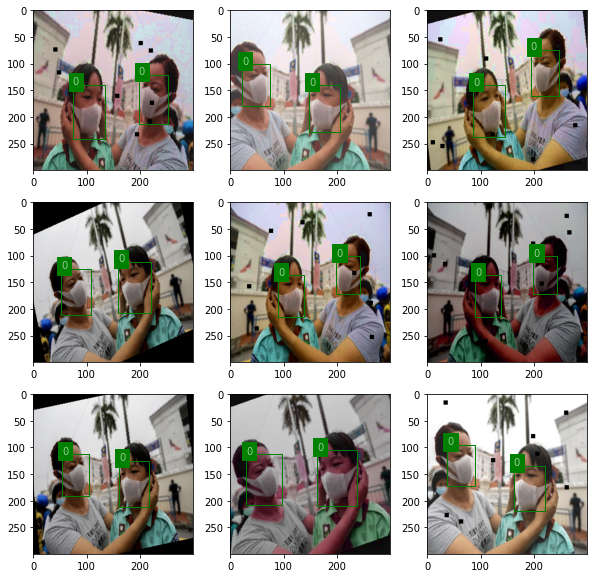

In [8]:
plt.figure(figsize=(10, 10))
for i in range(9):
    index = 336
    # index = np.random.randint(0, len(data))
    ax = plt.subplot(3, 3, i+1)
    entry = data[index]
    # a = augmentation(entry, rotate_prob=1.0, crop_prob=0.0, flip_prob=0.0)
    a = augmentation(entry)
    
    plt.imshow(a['img'])
    for l in a['label']:
        class_label = str(l['class_label'])
        # class_label = l['name']
        box = l['bounding_box']
        x = box[0]
        y = box[1]
        w = box[2] - box[0]
        h = box[3] - box[1]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], class_label, backgroundcolor='g', color='w', alpha=0.6)

plt.show()

In [9]:
test_index = np.random.randint(0, len(data))
entry = data[test_index]
%timeit augmentation(entry)

3.72 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
def compute_anchor_sizes(data, n=9):
    wh = []
    for entry in data:
        resized = image_resize(entry)
        for l in resized['label']:
            box = l['bounding_box']
            w = abs(box[0] - box[2])
            h = abs(box[1] - box[3])
            wh.append([w, h])
    kmeans = KMeans(n_clusters=n).fit(wh)
    return np.sort(kmeans.cluster_centers_, axis=0)


anchor_sizes = compute_anchor_sizes(data)
print(anchor_sizes)

[[  8.45567379  14.3150466 ]
 [ 15.97692179  26.70256879]
 [ 24.79582871  42.14570169]
 [ 35.52661704  50.2308617 ]
 [ 55.43924176  63.95294532]
 [ 60.12994138  91.07596547]
 [ 94.7917896   96.30629678]
 [107.77551354 114.43598336]
 [117.47723926 174.46451008]]


In [11]:
def get_anchors(img_size, num_classes, strides, num_anchors):
    anchor_sizes = compute_anchor_sizes(data, n=num_anchors)
    
    anchors = []
    for idx in range(len(strides)):
        s = strides[idx]
        d = img_size // s
        if img_size % s != 0:
            d += 1
        g = img_size / d # grid size
        local_anchors = np.zeros(shape=[d, d, 4 * num_anchors])
        for i in range(d):
            for j in range(d):
                for k in range(num_anchors):
                    local_anchors[i, j, k*4] = j * g + g / 2
                    local_anchors[i, j, k*4+1] = i * g + g / 2
                    local_anchors[i, j, k*4+2] = anchor_sizes[k][0]
                    local_anchors[i, j, k*4+3] = anchor_sizes[k][1]
        print('adding {}x{}x{} anchors'.format(d, d, num_anchors))
        anchors.append(local_anchors.reshape([d*d*num_anchors, 4]))
    return np.concatenate(anchors)


NUM_CLASSES = 3
NUM_ANCHORS = 9
anchors = get_anchors(IMAGE_SIZE, NUM_CLASSES, [4, 8, 16], NUM_ANCHORS)
print('anchors: ', anchors.shape)

adding 75x75x9 anchors
adding 38x38x9 anchors
adding 19x19x9 anchors
anchors:  (66870, 4)


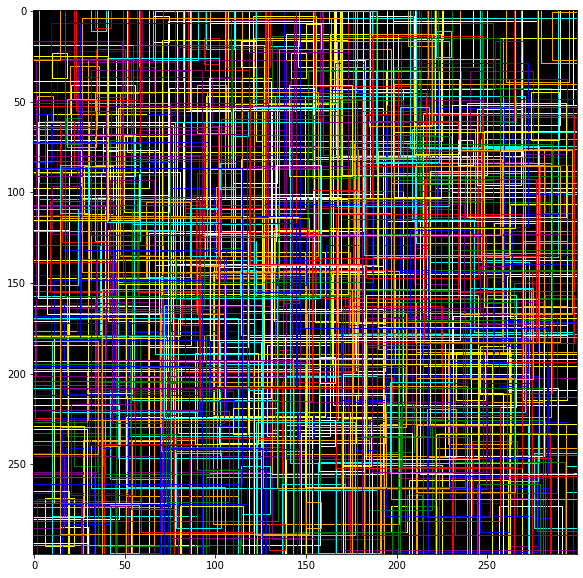

In [12]:
plt.figure(figsize=(10, 10))
ax = plt.gca()
plt.imshow(np.zeros([IMAGE_SIZE, IMAGE_SIZE, 3], dtype=np.uint8))
colors = ['r', 'g', 'b', 'white', 'cyan', 'orange', 'yellow', 'purple']
for k in range(600):
    index = np.random.randint(0, len(anchors))
    anchor = anchors[index]
    x = anchor[0] - anchor[2]/2
    y = anchor[1] - anchor[3]/2
    w = anchor[2]
    h = anchor[3]
    rect = patches.Rectangle((x, y), w, h, edgecolor=colors[k%len(colors)], facecolor='none')
    ax.add_patch(rect)
plt.show()

In [13]:
def IOU(anchors, bbox):
    """
    anchors: [[cx0, cy0, w0, h0],...,[cxn, cyn, wn, hn]]
    bbox: [x1, y1, x2, y2]
    """
    x1 = np.maximum(anchors[:, 0] - anchors[:, 2]/2, bbox[0])
    y1 = np.maximum(anchors[:, 1] - anchors[:, 3]/2, bbox[1])
    x2 = np.minimum(anchors[:, 0] + anchors[:, 2]/2, bbox[2])
    y2 = np.minimum(anchors[:, 1] + anchors[:, 3]/2, bbox[3])
    area_intersect = np.maximum(x2-x1, 0) * np.maximum(y2-y1, 0)
    area_anchors = anchors[:, 2] * anchors[:, 3]
    area_bounding_box = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
    iou = area_intersect / (area_anchors + area_bounding_box - area_intersect)
    # index = np.argsort(iou)[::-1]
    # print('max iou: ', np.max(iou))
    # print('bounding box: ', bbox)
    # print('best anchor: ', anchors[index[0]])
    return iou


def process_entry(entry, anchors, num_classes, ignore_threshold=0.33, penalty_threshold=0.66):
    """
    input:
        entry:
            'img': PIL.Image
            'label': array of
                'bounding_box': [x1, y1, x2, y2]
                'class_label': index of class
    
    output:
        image: np.array shape [IMAGE_SIZE, IMAGE_SIZE, 3]
        label: np.array shape [anchor_size, num_classes + 5]
    """
    img_data = np.array(entry['img'], np.float32)
    ious = []
    bounding_boxes = []
    classes = []
    for l in entry['label']:
        bbox = np.array(l['bounding_box'])
        iou = IOU(anchors, bbox)
        ious.append(iou)
        bounding_boxes.append(bbox)
        
        c = np.zeros(shape=[num_classes])
        c[l['class_label']] = 1
        classes.append(c)
    
    label = np.zeros(shape=[len(anchors), num_classes + 5], dtype=np.float32)
    if len(ious):
        ious = np.array(ious)
        target_index = np.argmax(ious, axis=0)
        target_value = np.max(ious, axis=0)
        valid_index = target_value > ignore_threshold
        # print('number of bounding box: ', len(entry['label']))
        # print('unique: ', np.unique(target_index))
        bounding_boxes = np.array(bounding_boxes)
        classes = np.array(classes)
        
        label[valid_index, 0] = 1.0 - np.maximum(penalty_threshold - target_value[valid_index], 0)
        label[valid_index, 1] = bounding_boxes[target_index[valid_index], 1] / IMAGE_SIZE
        label[valid_index, 2] = bounding_boxes[target_index[valid_index], 0] / IMAGE_SIZE
        label[valid_index, 3] = bounding_boxes[target_index[valid_index], 3] / IMAGE_SIZE
        label[valid_index, 4] = bounding_boxes[target_index[valid_index], 2] / IMAGE_SIZE
        label[valid_index, 5:] = classes[target_index[valid_index]]
    return img_data, label


index = np.random.randint(0, len(data))
#index = 336
print('index: ', index)
entry = data[index]
resized = image_resize(entry)
test_entry = {
    'img': np.array(resized['img']),
    'label': resized['label']
}
img_data, label_data = process_entry(test_entry, anchors, NUM_CLASSES)
print('image tensor: ', img_data.shape)
print('label tensor: ', label_data.shape)

index:  456
image tensor:  (300, 300, 3)
label tensor:  (66870, 8)


In [14]:
%timeit process_entry(test_entry, anchors, NUM_CLASSES)

7.31 ms ± 437 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


found:  306
found:  766
found:  742
found:  0
found:  824
found:  131


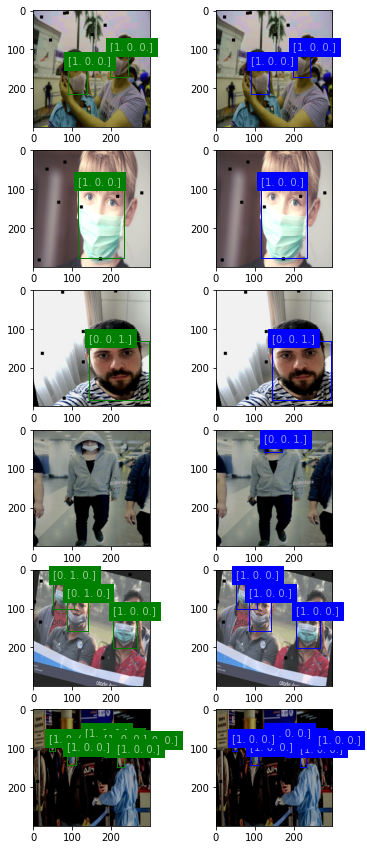

In [15]:
plt.figure(figsize=(6, 15))
show_count = 6
for i in range(show_count):
    plt.subplot(show_count, 2, i*2+1)
    index = np.random.randint(0, len(data))
    entry = data[index]
    a = augmentation(entry)
    img_data, label_data = process_entry(a, anchors, NUM_CLASSES, 0.5)
    plt.imshow(img_data / 255.0)
    ax = plt.gca()
    with_box = label_data[:, 0] > 0
    print('found: ', np.sum(with_box))
    for row in label_data[with_box]:
        x1 = row[2] * IMAGE_SIZE
        y1 = row[1] * IMAGE_SIZE
        x2 = row[4] * IMAGE_SIZE
        y2 = row[3] * IMAGE_SIZE
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor='g')
        ax.add_patch(rect)
        text_display = str(row[5:])
        ax.text(x1, y1, text_display, backgroundcolor='g', color='w', alpha=0.6)
    
    plt.subplot(show_count, 2, i*2+2)
    ax = plt.gca()
    plt.imshow(a['img'])
    for l in a['label']:
        bbox = l['bounding_box']
        x1 = bbox[0]
        y1 = bbox[1]
        x2 = bbox[2]
        y2 = bbox[3]
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor='b')
        ax.add_patch(rect)
        text_display = str(row[5:])
        ax.text(x1, y1, text_display, backgroundcolor='b', color='w', alpha=0.6)

In [16]:
def conv2d(x, output_size, filter_size, stride):
    x = keras.layers.Conv2D(output_size, filter_size, stride, padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    return x


def residule(x, output_size, filter_size, stride):
    x1 = conv2d(x, output_size, filter_size, stride)
    return keras.layers.Add()([x1, x])


def create_model(num_classes, num_anchor_box, anchor_tensor):
    img_inputs = keras.Input(shape=[IMAGE_SIZE, IMAGE_SIZE, 3])
    x = img_inputs / 255.0
    x = conv2d(x, 32, 3, 2)
    x = conv2d(x, 64, 3, 2)
    x = residule(x, 64, 3, 1)
    x = keras.layers.Dropout(0.3)(x)

    output_dim = (num_classes + 5) * num_anchor_box
    y1 = keras.layers.Conv2D(output_dim, 3, 1, padding='same', activation=None)(x)
    d = IMAGE_SIZE // 4
    y1 = tf.reshape(y1, [-1, d*d*num_anchor_box, num_classes + 5])
    
    x = conv2d(x, 128, 3, 2)
    x = keras.layers.Dropout(0.3)(x)
    x = residule(x, 128, 3, 1)
    
    y2 = keras.layers.Conv2D(output_dim, 3, 1, padding='same', activation=None)(x)
    d = IMAGE_SIZE // 8 + 1
    y2 = tf.reshape(y2, [-1, d*d*num_anchor_box, num_classes + 5])
    
    x = conv2d(x, 256, 3, 2)
    x = keras.layers.Dropout(0.3)(x)
    x = residule(x, 256, 3, 1)
    
    y3 = keras.layers.Conv2D(output_dim, 3, 1, padding='same', activation=None)(x)
    d = IMAGE_SIZE // 16 + 1
    y3 = tf.reshape(y3, [-1, d*d*num_anchor_box, num_classes + 5])
    
    y = tf.concat([y1, y2, y3], axis=1)
    loc, box, classes = tf.split(y, [1, 4, num_classes], axis=2)
    loc, tx, ty, tw, th, classes = tf.split(y, [1, 1, 1, 1, 1, num_classes], axis=2)
    bx = tx + anchor_tensor[:, 0:1] / IMAGE_SIZE
    by = ty + anchor_tensor[:, 1:2] / IMAGE_SIZE
    bw = tw + anchor_tensor[:, 2:3] / IMAGE_SIZE
    bh = th + anchor_tensor[:, 3:4] / IMAGE_SIZE
    y = tf.concat([loc, by-bh/2, bx-bw/2, by+bh/2, bx+bw/2, classes], axis=2)
    
    model = keras.Model(inputs=[img_inputs], outputs=[y])
    return model


keras.backend.clear_session()
anchor_tensor = tf.constant(anchors, tf.float32)
model = create_model(NUM_CLASSES, NUM_ANCHORS, anchor_tensor)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         tf.math.truediv[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [17]:
BATCH_SIZE = 32
ROTATE_PROB = 0.5
MAX_ROTATE_DEGREE = 20.0
CROP_PROB = 0.5
CROP_PERCENT = 0.7
FLIP_PROB = 0.5

def process_batch(batch, anchors, num_classes):
    image_data = []
    label_data = []
    for entry in batch:
        a = augmentation(entry,
                         rotate_prob=ROTATE_PROB,
                         max_degree=MAX_ROTATE_DEGREE,
                         crop_prob=CROP_PROB,
                         crop_percent=CROP_PERCENT,
                         flip_prob=FLIP_PROB)
        p = process_entry(a, anchors, num_classes)
        image_data.append(p[0])
        label_data.append(p[1])
    return np.array(image_data), np.array(label_data)


index = np.random.randint(0, len(data)-BATCH_SIZE)
test_image_data, test_label_data = process_batch(data[index:index+BATCH_SIZE], anchors, NUM_CLASSES)
print('image data: ', test_image_data.shape)
print('label data: ', test_label_data.shape)

image data:  (32, 300, 300, 3)
label data:  (32, 66870, 8)


In [18]:
%timeit process_batch(data[index:index+BATCH_SIZE], anchors, NUM_CLASSES)

403 ms ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
def bounding_box_loss(y, logits, epsilon=1e-3):
    loc = y[:, :, 0:1]
    error = y[:, :, 1:5] - logits[:, :, 1:5]
    return tf.reduce_sum(tf.square(error) * loc) / (tf.reduce_sum(loc) + epsilon)


def class_loss(y, logits, epsilon=1e-3):
    soft_max_loss = tf.nn.softmax_cross_entropy_with_logits(y[:, :, 5:], logits[:, :, 5:])
    loc = y[:, :, 0]
    return tf.reduce_sum(soft_max_loss * loc) / (tf.reduce_sum(loc) + epsilon)


def loss_fn(y, logits, alpha, epsilon=1e-3):
    obj_loc = y[:, :, 0]
    empty_loc = 1.0 - y[:, :, 0]
    loc_loss = tf.nn.sigmoid_cross_entropy_with_logits(y[:, :, 0], logits[:, :, 0])
    obj_loss = alpha * tf.reduce_sum(loc_loss * obj_loc) / (tf.reduce_sum(obj_loc) + epsilon) + \
        (1.0 - alpha) * tf.reduce_sum(loc_loss * empty_loc) / (tf.reduce_sum(empty_loc) + epsilon)
    
    box_loss = bounding_box_loss(y, logits, epsilon=epsilon)
    obj_class_loss = class_loss(y, logits, epsilon=epsilon)
    return obj_loss + box_loss + obj_class_loss


def train_step(x, y, optimizer, alpha=0.5, epsilon=1e-3):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits, alpha=alpha, epsilon=epsilon)
        grads = tape.gradient(loss_value, model.trainable_weights)
        
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value


ALPHA = 0.06
index = np.random.randint(0, len(data)-BATCH_SIZE)
test_image_data, test_label_data = process_batch(data[index:index+BATCH_SIZE], anchors, NUM_CLASSES)
adam = keras.optimizers.Adam(2e-4)
loss_value = train_step(test_image_data, test_label_data, adam, alpha=ALPHA)

print('Training loss at step: %.4f' % (float(loss_value)))

test_prediction = model.predict(test_image_data)
print('mean loc: ', np.mean(test_prediction[:, :, 0]))
print('std loc: ', np.std(test_prediction[:, :, 0]))
print('mean box: ', np.mean(test_prediction[:, :, 1:5]))
print('std box: ', np.std(test_prediction[:, :, 1:5]))
print('mean classes: ', np.mean(test_prediction[:, :, 5:]))
print('std classes: ', np.std(test_prediction[:, :, 5:]))

Training loss at step: 11.3633
mean loc:  -0.016208233
std loc:  0.09837479
mean box:  0.5200287
std box:  0.33043358
mean classes:  -0.00445722
std classes:  0.1201695


In [20]:
train_data, valid_data = train_test_split(data, test_size=0.06)
print('train data size: ', len(train_data))
print('valid data size: ', len(valid_data))

train data size:  805
valid data size:  52


In [21]:
def process_validation_data(batch):
    validation_images = []
    validation_labels = []
    for entry in batch:
        resized = image_resize(entry)
        p = process_entry(resized, anchors, NUM_CLASSES)
        validation_images.append(p[0])
        validation_labels.append(p[1])
    return np.array(validation_images), np.array(validation_labels)


def validation_score(validation_data):
    val_loss = []
    for index in range(0, len(validation_data)-BATCH_SIZE, BATCH_SIZE):
        valid_images, valid_labels = process_validation_data(validation_data[index:index+BATCH_SIZE])
        val_prediction = model(valid_images, training=False)
        loss = loss_fn(valid_labels, val_prediction, alpha=ALPHA)
        val_loss.append(loss.numpy())
    print('validation loss: ', np.mean(val_loss))
    return np.mean(val_loss)


def train(train_data, validation_data, num_epochs, optimizer):
    train_loss = []
    val_loss = []
    for epoch in range(num_epochs):
        step = 0
        for index in range(0, len(train_data)-BATCH_SIZE, BATCH_SIZE):
            batch = train_data[index:index+BATCH_SIZE]
            image_data, label_data = process_batch(batch, anchors, NUM_CLASSES)
            loss = train_step(image_data, label_data, optimizer, alpha=ALPHA)
            if step == 0:
                print('Training loss at %d: %.4f' % (epoch+1, float(loss)))
            step += 1
        train_loss.append(loss)
        val_loss.append(validation_score(validation_data))
    return train_loss, val_loss


learning_rate = keras.optimizers.schedules.ExponentialDecay(3e-4, 50 * len(train_data), 0.336)
NUM_EPOCHS = 220
adam = keras.optimizers.Adam(learning_rate=learning_rate)
train_loss, val_loss = train(train_data, valid_data, NUM_EPOCHS, adam)

Training loss at 1: 11.3644
validation loss:  1.498323
Training loss at 2: 3.0702
validation loss:  1.2790666
Training loss at 3: 2.6296
validation loss:  1.111852
Training loss at 4: 2.0531
validation loss:  0.99888957
Training loss at 5: 1.6683
validation loss:  0.9349828
Training loss at 6: 1.5833
validation loss:  0.9053493
Training loss at 7: 1.4073
validation loss:  0.9053416
Training loss at 8: 1.3728
validation loss:  0.9163379
Training loss at 9: 1.2605
validation loss:  0.93477947
Training loss at 10: 1.1489
validation loss:  0.9069817
Training loss at 11: 1.0484
validation loss:  0.8761393
Training loss at 12: 0.9295
validation loss:  0.8517484
Training loss at 13: 0.9183
validation loss:  0.8598032
Training loss at 14: 0.9973
validation loss:  0.82510245
Training loss at 15: 0.8828
validation loss:  0.804475
Training loss at 16: 0.8212
validation loss:  0.7980855
Training loss at 17: 0.8213
validation loss:  0.7719515
Training loss at 18: 0.8833
validation loss:  0.7594579


Training loss at 146: 0.4626
validation loss:  0.6063854
Training loss at 147: 0.5222
validation loss:  0.60439384
Training loss at 148: 0.5226
validation loss:  0.61755013
Training loss at 149: 0.5127
validation loss:  0.6152056
Training loss at 150: 0.4619
validation loss:  0.6025189
Training loss at 151: 0.5205
validation loss:  0.5936368
Training loss at 152: 0.5916
validation loss:  0.59969974
Training loss at 153: 0.4333
validation loss:  0.58950526
Training loss at 154: 0.4433
validation loss:  0.59520763
Training loss at 155: 0.4881
validation loss:  0.5925205
Training loss at 156: 0.4766
validation loss:  0.6099424
Training loss at 157: 0.5219
validation loss:  0.6049649
Training loss at 158: 0.4250
validation loss:  0.6168394
Training loss at 159: 0.5216
validation loss:  0.5997866
Training loss at 160: 0.4859
validation loss:  0.5964667
Training loss at 161: 0.5057
validation loss:  0.6069165
Training loss at 162: 0.5502
validation loss:  0.584965
Training loss at 163: 0.486

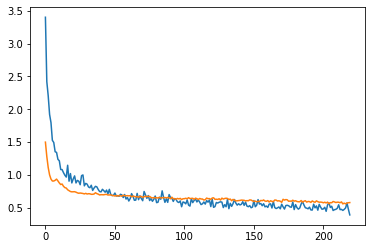

In [22]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [23]:
learning_rate = keras.optimizers.schedules.ExponentialDecay(5e-5, 100 * len(train_data), 0.336)
adam = keras.optimizers.Adam(learning_rate=learning_rate)
train_loss2, val_loss2 = train(train_data, valid_data, 100, adam)

Training loss at 1: 0.4909
validation loss:  0.56094694
Training loss at 2: 0.3859
validation loss:  0.55709743
Training loss at 3: 0.4441
validation loss:  0.5583807
Training loss at 4: 0.4692
validation loss:  0.5530441
Training loss at 5: 0.4435
validation loss:  0.55569506
Training loss at 6: 0.4612
validation loss:  0.5618766
Training loss at 7: 0.4582
validation loss:  0.56279886
Training loss at 8: 0.4181
validation loss:  0.5577285
Training loss at 9: 0.4732
validation loss:  0.55747163
Training loss at 10: 0.4669
validation loss:  0.5496726
Training loss at 11: 0.3850
validation loss:  0.55257475
Training loss at 12: 0.5639
validation loss:  0.5526742
Training loss at 13: 0.4661
validation loss:  0.5496095
Training loss at 14: 0.3868
validation loss:  0.55400264
Training loss at 15: 0.5359
validation loss:  0.55755246
Training loss at 16: 0.4599
validation loss:  0.5549912
Training loss at 17: 0.4037
validation loss:  0.560326
Training loss at 18: 0.4800
validation loss:  0.55

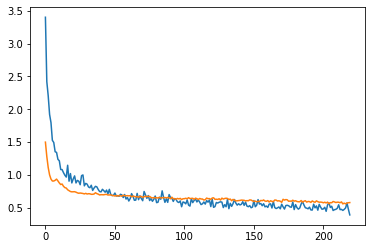

In [27]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

(6, 300, 300, 3)
found boxes:  80
found boxes:  9
found boxes:  71
found boxes:  121
found boxes:  29
found boxes:  177


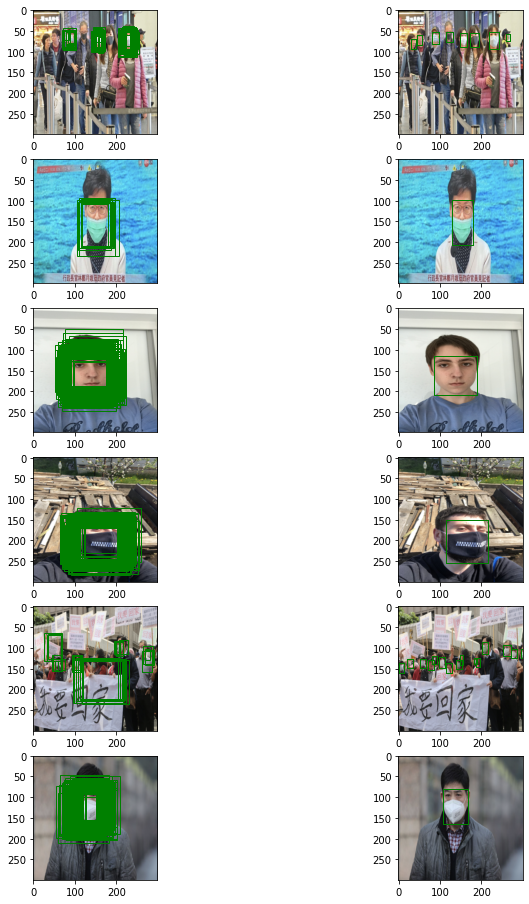

In [24]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def show_prediction(images, prediction, valid_labels, threshold=0.75):
    plt.figure(figsize=(12, 16))
    n = len(prediction)
    for i, p in enumerate(prediction):
        loc = sigmoid(p[:, 0])
        found = loc >= threshold
        plt.subplot(n, 2, i*2+1)
        plt.imshow(images[i] / 255.0)
        ax = plt.gca()
        print('found boxes: ', np.sum(found))
        for row in p[found]:
            x1 = row[2] * IMAGE_SIZE
            y1 = row[1] * IMAGE_SIZE
            x2 = row[4] * IMAGE_SIZE
            y2 = row[3] * IMAGE_SIZE
            w = x2-x1
            h = y2-y1
            rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor='g')
            ax.add_patch(rect)
            
        plt.subplot(n, 2, i*2+2)
        plt.imshow(images[i] / 255.0)
        ax = plt.gca()
        found = valid_labels[i, :, 0] >= threshold
        for row in valid_labels[i, found]:
            x1 = row[2] * IMAGE_SIZE
            y1 = row[1] * IMAGE_SIZE
            x2 = row[4] * IMAGE_SIZE
            y2 = row[3] * IMAGE_SIZE
            w = x2-x1
            h = y2-y1
            rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor='g')
            ax.add_patch(rect)


valid_batch = valid_data[:6]
valid_images, valid_labels = process_validation_data(valid_batch)
print(valid_images.shape)
p = model.predict(valid_images)
show_prediction(valid_images, p, valid_labels)

found boxes:  4
found boxes:  18
found boxes:  6


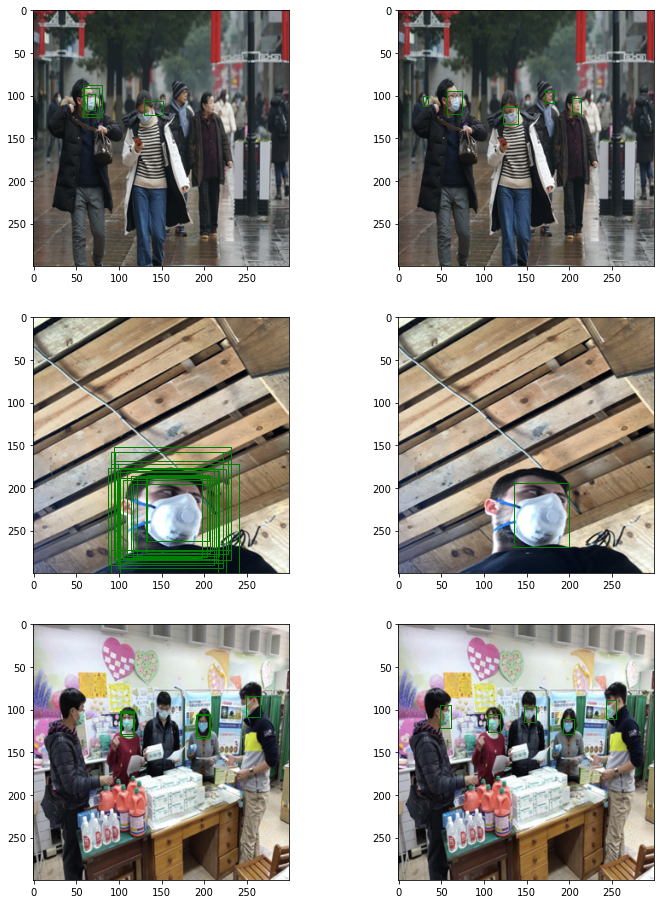

In [25]:
valid_batch = train_data[:3]
valid_images, valid_labels = process_validation_data(valid_batch)
p = model.predict(valid_images)
show_prediction(valid_images, p, valid_labels)

In [26]:
keras.models.save_model(model, 'version4')

INFO:tensorflow:Assets written to: version4/assets


In [28]:
MAX_OUTPUT_SIZE = 300


@tf.function
def process(y,
            iou_threshold=tf.constant(0.2),
            score_threshold=tf.constant(0.5)):
    loc, boxes, classes = tf.split(y, [1, 4, 3], axis=1)
    loc = tf.sigmoid(loc)
    scores = tf.squeeze(loc)
    selected = tf.image.non_max_suppression(boxes,
                                            scores,
                                            max_output_size=MAX_OUTPUT_SIZE,
                                            iou_threshold=iou_threshold,
                                            score_threshold=score_threshold,
                                            name='non_max_suppression')
    classes = tf.nn.softmax(classes, axis=1)
    selected_loc = tf.gather(loc, selected)
    selected_boxes = tf.gather(boxes, selected)
    selected_classes = tf.gather(classes, selected)

    y2 = tf.concat([selected_loc, selected_boxes, selected_classes], axis=1)
    count = tf.shape(y2)[0]
    y2 = tf.cond(count > MAX_OUTPUT_SIZE,
                 lambda: y2,
                 lambda: tf.pad(y2, [[0, MAX_OUTPUT_SIZE-count], [0, 0]]))
    return y2


@tf.function
def process_batch(x):
    return tf.map_fn(process, x)


def post_process(model):
    raw_output = model.outputs[0]
    output = keras.layers.Lambda(lambda x: process_batch(x))(raw_output)
    wrap_model = keras.Model(inputs=model.inputs, outputs=[output])
    return wrap_model


wrap_model = post_process(model)
wrap_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv (TFOpLambda)    (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 896         tf.math.truediv[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d[0][0]                     
____________________________________________________________________________________________

(3, 300, 300, 3)
(3, 300, 8)


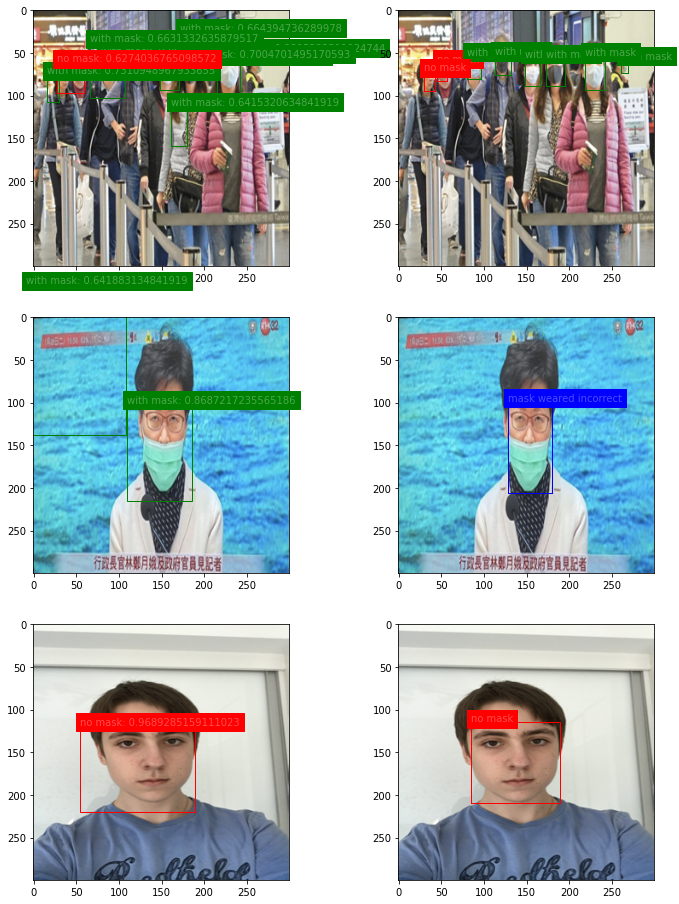

In [29]:
def display_label(c):
    if c == 0:
        return 'with mask', 'g'
    elif c == 1:
        return 'mask weared incorrect', 'b'
    else:
        return 'no mask', 'r'


def show_post_process_result(images, result, valid_labels):
    plt.figure(figsize=(12, 16))
    n = len(images)
    for i, img in enumerate(images):
        plt.subplot(n, 2, i*2+1)
        plt.imshow(img / 255.0)
        ax = plt.gca()
        for r in result[i]:
            if r[0] <= 0.6:
                continue
            y1 = r[1] * IMAGE_SIZE
            x1 = r[2] * IMAGE_SIZE
            y2 = r[3] * IMAGE_SIZE
            x2 = r[4] * IMAGE_SIZE
            w = x2 - x1
            h = y2 - y1
            c = np.argmax(r[5:])
            text, color = display_label(c)
            rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor=color)
            ax.add_patch(rect)
            ax.text(x1, y1, '{}: {}'.format(text, r[0]), backgroundcolor=color, color='w', alpha=0.3)
            
        plt.subplot(n, 2, i*2+2)
        plt.imshow(img / 255.0)
        ax = plt.gca()
        found = valid_labels[i, :, 0] >= 0.5
        for row in valid_labels[i, found]:
            x1 = row[2] * IMAGE_SIZE
            y1 = row[1] * IMAGE_SIZE
            x2 = row[4] * IMAGE_SIZE
            y2 = row[3] * IMAGE_SIZE
            w = x2-x1
            h = y2-y1
            c = np.argmax(row[5:])
            text, color = display_label(c)
            rect = patches.Rectangle((x1, y1), w, h, facecolor='none', edgecolor=color)
            ax.add_patch(rect)
            ax.text(x1, y1, text, backgroundcolor=color, color='w', alpha=0.3)


valid_batch = valid_data[:3]
valid_images, valid_labels = process_validation_data(valid_batch)
print(valid_images.shape)
result = wrap_model.predict(valid_images)
print(result.shape)
show_post_process_result(valid_images, result, valid_labels)

In [30]:
keras.models.save_model(wrap_model, 'version4.1')

INFO:tensorflow:Assets written to: version4.1/assets
